# Baseline Models and Forecast Methods

Recall from our regression lessons that an important step in predictive modeling is establishing a baseline for comparison purposes. Let's introduce a few options for time series forecasting.

## What we will accomplish

In this notebook we will:
- Introduce six baseline models:
    - For data without trend or seasonality:
        - A gaussian white noise model which gives us the "average" forecast
        - A gaussian random walk forecast which gives us the "naive" forecast
    - For data with trend but not seasonality:
        - A linear trend model
        - A random walk with drift model
    - Forecasts for data with seasonality but not trend:
        - A deterministic seasonality with gaussian white noise model, which gives the "seasonal average" forecast
        - A seasonal random walk model

- And discuss error measurement for forecasting.

### Notation

Throughout this notebook we will assume that $y_t$ is a time series, that the training set has $n$ observations and that we are interested in predicting observations at times $t > n$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from seaborn import set_style
from sklearn.metrics import mean_squared_error

set_style("whitegrid")

## Three data sets

Let's create $3$ fake time series corresponding to each of the three situations we are considering.

In [2]:
# Note:  These examples all have y_t independent from y_s for all t,s.
# In that sense they are not typical time series.

no_trend = 5 + np.random.normal(size = 100)
trend = 5 + 2 * np.arange(100) + 10*np.random.normal(size = 100)
seasonality = 5 + 2 * np.sin(np.arange(100) * 2 * np.pi / 12 ) + np.random.normal(size = 100)

no_trend_train = no_trend[:80]
no_trend_test = no_trend[80:]

trend_train = trend[:80]
trend_test = trend[80:]

seasonality_train = seasonality[:80]
seasonality_test = seasonality[80:]

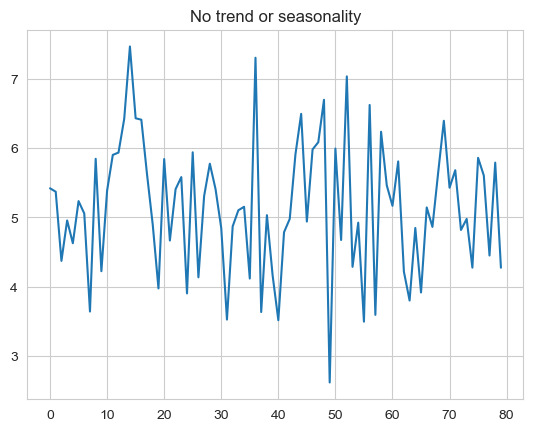

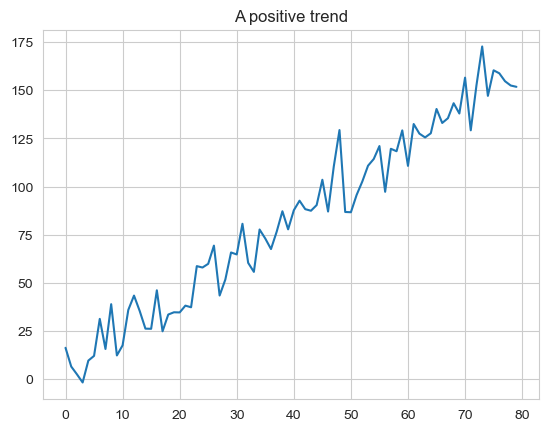

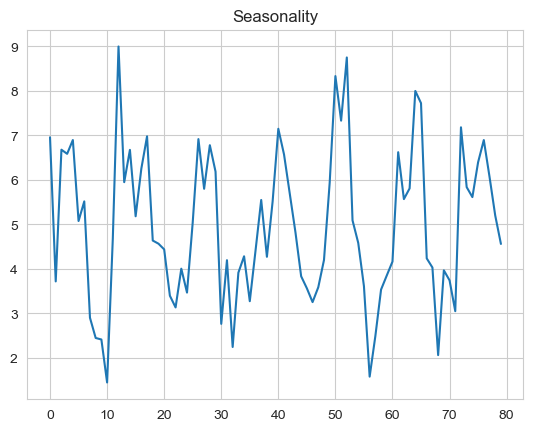

In [3]:
plt.plot(np.arange(80), no_trend_train)
plt.title("No trend or seasonality")
plt.show()

plt.plot(np.arange(80), trend_train)
plt.title("A positive trend")
plt.show()

plt.plot(np.arange(80), seasonality_train)
plt.title("Seasonality")
plt.show()

## Two baseline models for time series without trend or seasonality

### A Gaussian white noise model.

One baseline model is the <i>Gaussian white noise model</i>.  

We hypothesize a data generating process of the form:

$$
f(t) = \mu + \epsilon_t
$$

with $\mu$ as some constant and $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$.  In this context we can call our error terms "Gaussian white noise".

The MLE fitted model will have $\hat{\mu} = \displaystyle \frac{1}{n}\sum_{i=1}^n y_i$, and $\hat{\sigma}^2 = \displaystyle \frac{1}{n} \sum_{i=1}^n (y - \hat{\mu})^2$.

### Average Forecast

This leads to the **average forecast**:  To predict the value of $y_t$ for $t>n$ we just report $\hat{\mu} = \displaystyle \frac{1}{n}\sum_{i=1}^n y_i$.

<i>Note: for this estimate to be "good" the assumption that the $y_t$ are independent and identically distributed</i>.

In [4]:
## Making the average "prediction"
average_forecast = no_trend_train.mean() * np.ones(20)

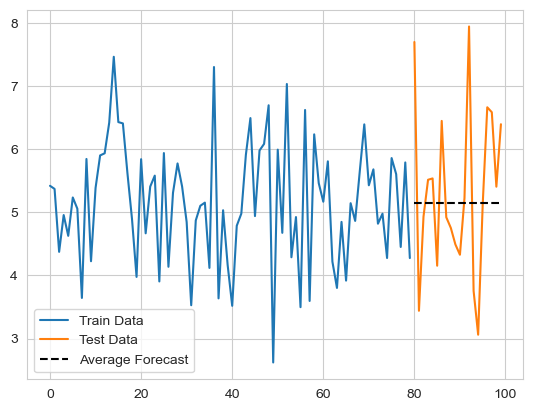

In [5]:
## Plotting the average prediction with the actual data
plt.plot(np.arange(80), no_trend_train, label = 'Train Data')
plt.plot(np.arange(80, 100), no_trend_test, label = 'Test Data')
plt.plot(np.arange(80, 100), average_forecast, '--k', label = 'Average Forecast')
plt.legend()
plt.show()

### A Gaussian Random Walk Model

Another baseline you may consider is a **Gaussian Random Walk** model, which is the process

$$
y_t = y_{t-1} + \epsilon_t
$$

where $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$.

We fit this model by computing $\hat{\sigma}^2 = \frac{1}{n} \displaystyle \sum_1^n (y_t - y_{t-1})^2$.

### Naive Forecast
This leads to the **naive forecast** which is just to set $y_t = y_n$ for $t>n$.  In other words, we just predict the last observed value!



In [6]:
## Making the naive forecast
naive_forecast = no_trend_train[-1] * np.ones(20)

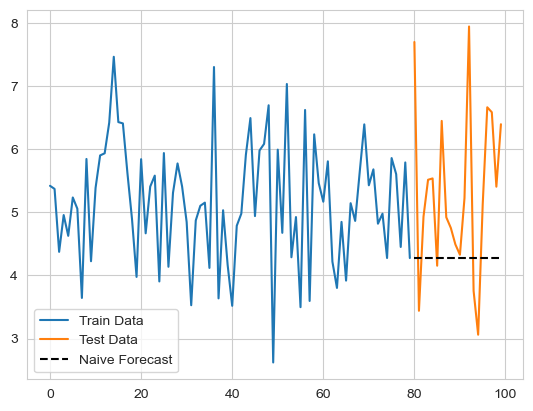

In [7]:
## Plotting the naive forecast with the actual data
plt.plot(np.arange(80), no_trend_train, label = 'Train Data')
plt.plot(np.arange(80, 100), no_trend_test, label = 'Test Data')
plt.plot(np.arange(80, 100), naive_forecast, '--k', label = 'Naive Forecast')
plt.legend()
plt.show()

## Data with trend but no seasonality

These two forecasts can serve as decent baselines for data sets with a linear trend but no seasonality.

### A linear trend model

A baseline linear trend model will assume that the time series is a linear function of time plus some random noise, i.e.:

$$
f(t) = \beta_0 + \beta_1 t + \epsilon_t
$$

where $\beta_0, \beta_1 \in \mathbb{R}$ and $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$ is guassian white noise error term.


#### Fitting the model

To estimate $\beta_0, \ \beta_1$ we can fit a linear regression model using the time point as the feature you are regressing on.

####  Linear trend forecast

Our forecase simply predicts $y_t = \beta_0 + \beta_1 t$ for $t>n$.

In [8]:
## import linear regression
from sklearn.linear_model import LinearRegression

In [9]:
## Make the model object
reg = LinearRegression()

## Fit the model
reg.fit(np.arange(80).reshape(-1,1),trend_train)

## Make the forecast
linear_trend_forecast = reg.predict(np.arange(80,100).reshape(-1,1))

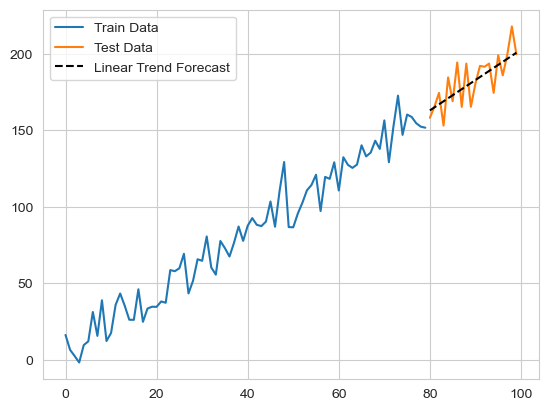

In [10]:
## Plotting the linear trend forecast with the actual data
plt.plot(np.arange(80), trend_train, label = 'Train Data')
plt.plot(np.arange(80, 100), trend_test, label = 'Test Data')
plt.plot(np.arange(80, 100), linear_trend_forecast, '--k', label = 'Linear Trend Forecast')
plt.legend()
plt.show()

### A random walk with drift

The model is:

$$
y_0 = \beta_0 \ \ \text{ and } \ \ y_{t+1} = y_{t} + \beta_1 + \epsilon_t
$$


where $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$ is guassian white noise error term.

This is similar to the linear model, but the data generating process is different.  The MLE estimates of the parameters are

$$
\begin{align*}
\hat{\beta}_1 &= \frac{1}{n}\sum_{i=1}^n (y_i - y_{i-1}) = \frac{1}{n} (y_n - y_0)\\
\hat{\beta}_0 &= y_0\\
\hat{\sigma}^2 &= \frac{1}{n}\sum_{i=1}^n (y_i - y_{i-1} - \hat{\beta}_1)^2
\end{align*}
$$

### Drift forecast

This leads to a **drift forecast** where we predict $y_t = y_n + \beta_1 (t-n)$ for $t > n$.

In [11]:
slope = (trend_train[-1] - trend_train[0])/len(trend_train)
intercept = trend_train[0]

drift_model = np.vectorize(lambda t: intercept + slope * t)

drift_forecast = drift_model(np.arange(80,100))

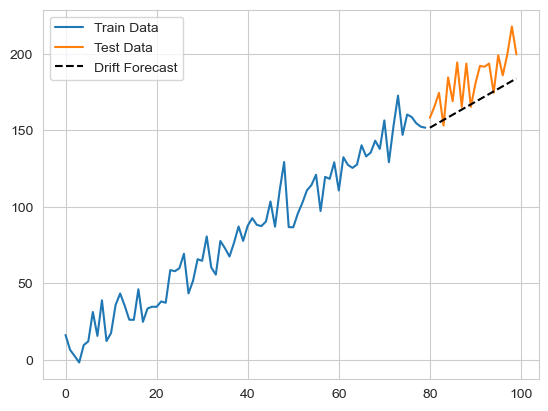

In [12]:
## Plotting the linear trend forecast with the actual data
plt.plot(np.arange(80), trend_train, label = 'Train Data')
plt.plot(np.arange(80, 100), trend_test, label = 'Test Data')
plt.plot(np.arange(80, 100), drift_forecast, '--k', label = 'Drift Forecast')
plt.legend()
plt.show()

## Data with seasonality but no trend

## Seasonal average model

The seasonal average model assumes that each "season" is independently following a gaussian white noise model, where each season has a different mean but a common variance.

For season $j = 0,1,2,..., T-1$ let $D_{t,j}$ be a dummy variable with

$$
D_{t,j} = 
\begin{cases}
1 \textrm{ if } t \equiv j \mod T\\
0 \textrm{ else}
\end{cases}
$$

Then our statistical model is 

$$
\begin{align*}
y_t = &\epsilon_t + \sum_0^{T-1} \beta_j D_{t,j} \\
&\epsilon_t \sim \operatorname{NID}(0,\sigma^2)
\end{align*}
$$

The MLE fit model has 

- $\hat{\beta}_j$ is the mean value for the season, in other words the average of $y_{j}, y_{j+T}, y_{j+2T}, ...$
- $\hat{\sigma^2}$ is the variance of the residuals

## Seasonal average forecast

This leads to the **seasonal average forecast** where we simply report predicted value for a new $y_t$ with $t>n$ as the average of all observations in the same period $y_{t-T}, y_{t-2T}, y_{t-3T}, ...$

In [13]:
seasonality_averages = np.ones(12)

for i in range(12):
    seasonality_averages[i] = seasonality_train[np.arange(80)%12 == i].mean()

seasonality_forecast = np.ones(20)
for i, j in enumerate(np.arange(80,100)):
    seasonality_forecast[i] = seasonality_averages[j%12]

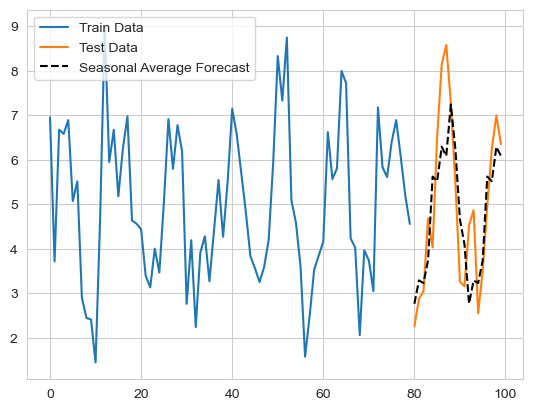

In [14]:
## Plotting the linear trend forecast with the actual data
plt.plot(np.arange(80), seasonality_train, label = 'Train Data')
plt.plot(np.arange(80, 100), seasonality_test, label = 'Test Data')
plt.plot(np.arange(80, 100), seasonality_forecast, '--k', label = 'Seasonal Average Forecast')
plt.legend()
plt.show()

## Seasonal random walk model

The seasonal random walk model is that each season is independently following a gaussian random walk with the same variance.

In other words we have

$$
\begin{align*}
y_t &= y_{t-T} + \epsilon_t\\
\epsilon_t &\sim \operatorname{NID}(0,\sigma^2)
\end{align*}
$$

We fit this model by computing $\hat{\sigma}^2 = \frac{1}{n - T} \displaystyle \sum_{T+1}^n (y_t - y_{t-T})^2$.

## Seasonal naive prediction

This leads to the seasonal naive prediction where we predict $y_t$ to be the corresponding value from the most recently observed season.

In [15]:
last_training_example_times = np.arange(80)[-12:]
last_training_example_values = seasonality_train[-12:]
seasonal_lookup = {last_training_example_times[i]%12: last_training_example_values[i] for i in range(12)}

In [16]:
seasonal_naive_forecast = np.array([seasonal_lookup[x%12] for x in np.arange(80,100)])

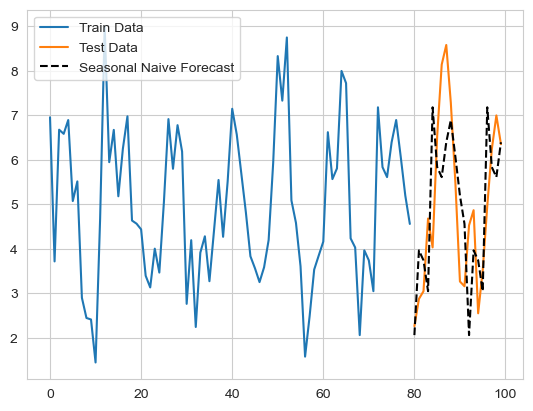

In [17]:
plt.plot(np.arange(80), seasonality_train, label = 'Train Data')
plt.plot(np.arange(80, 100), seasonality_test, label = 'Test Data')
plt.plot(np.arange(80, 100), seasonal_naive_forecast, '--k', label = 'Seasonal Naive Forecast')
plt.legend()
plt.show()

## Wrapping up

You now have six baselines to choose from depending on your data. While we did not cover baseline options for time series that exhibit both a trend and seasonality, there are extensions of the white noise and random walk models that can be used to produce forecasts for such data. This extension is left to the corresponding `Practice Problems` notebook.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.  Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)